<h1><center>IST 707: Data Analytics</center>
<center>HW4:  Statistical Learning, Deep Learning and A Complete Comparison</center></h1>

<h2><left>Name: Tanishk Parihar</left>
<br><left>Date of Submission: 04/26/2020</left></h2>

## Problem Statement

In this homework assignment, we have to make use of multiple machine learning algorithms, including logistic
regression, multiple artificial neural networks and deep learning models with different architectures to build
disease diagnosis models. It is a binary classification problem to predict whether or not a patient has a certain unspecified disease. We will also combine the findings with HW3 results to come up with a ranking of performance for various machine learning models on this dataset.

## Dataset
**Attributes’ information about the dataset:**<br>
• Age: in years<br>
• Gender: male/female<br>
• Height: in unit of cm<br>
• Weight: in unit of kg<br>
• Low Blood Pressure: lower bound of blood pressure measurement<br>
• High Blood Pressure: higher bound of blood pressure measurement<br>
• Cholesterol: three cholesteral levels<br>
• Glucose: three glucose levels<br>
• Smoke: 1/0 regarding if the patient smokes<br>
• Alcohol: 1/0 regarding if the patient drinks alcohol<br>
• Exercise: 1/0 regarding if the patient exercises regularly<br>
***• Disease: The binary target variable. Does the patient have the disease?***<br>

In [1]:
#Importing all required libraries
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
import numpy as np
import tensorflow as tf
import random as rn
import os
os.environ['PYTHONHASHSEED'] = '0'
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.metrics import accuracy_score,recall_score,classification_report,precision_score,roc_auc_score,f1_score,roc_curve
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from collections import OrderedDict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from keras import models
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


## Data Preparation

In [2]:
#Reads both the data as we will be cleaning both the data simultaneously
data=pd.read_csv("Disease Prediction Training.csv")
test=pd.read_csv("Disease Prediction Testing.csv")

In [3]:
#Duplicate rows will be dropped as it will only create noise in our data
data.drop_duplicates(keep='first',inplace=True)

In [4]:
# We check for any null values in our dataset
data.isna().sum().sum()

0

In [5]:
#We do the same for the test set
test.isna().sum().sum()

0

In [6]:
# The value counts for the two classes to check if there is an imbalance  
data.Disease.value_counts()

1    24076
0    23172
Name: Disease, dtype: int64

**First we will create a BMI column, which I believe can help us to tell if a person's healthy or not, having a high BMI means a person is obese which increases the chance of person suffering from the disease. So, I think it will significantly help us in classifying our target. We can later check if this variable is helpful in our classification task by printing the feature importance of the tree algorithms.**

**BMI is calculated using weight and height, so we will first check if there is any outlier data in both the columns.**

We can clearly see that our Height data contains outlier because our data is highly skewed.


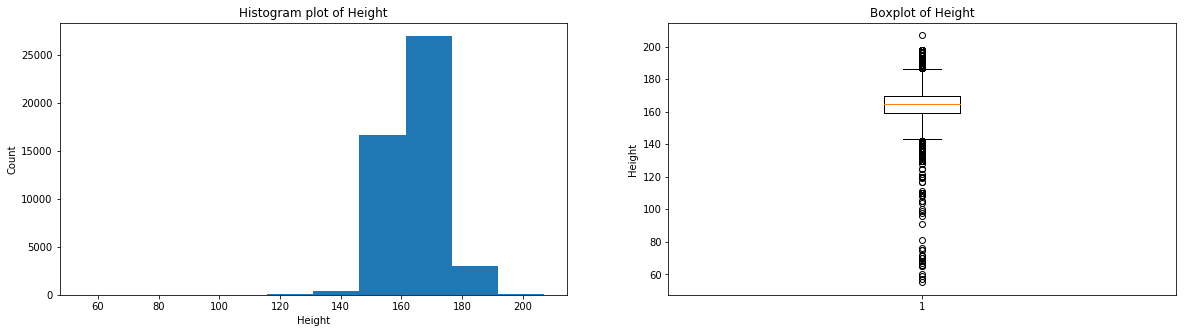

In [7]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data.Height);
ax[0].set_title("Histogram plot of Height")
ax[0].set_xlabel("Height")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Height")
ax[1].set_title("Boxplot of Height")
ax[1].boxplot(data.Height);
print("We can clearly see that our Height data contains outlier because our data is highly skewed.")

**It is very unlikely we will see people who have a height less than 120 cm given that the age of people in our data is more 20 years. So, we can clip the lower limit to 120 cm. The higher values of the data seems fine.**

In [8]:
data.Height=data["Height"].clip(lower=120)
test.Height=test["Height"].clip(lower=120)

We can clearly see that our Weight data contains outlier because our data is highly skewed.


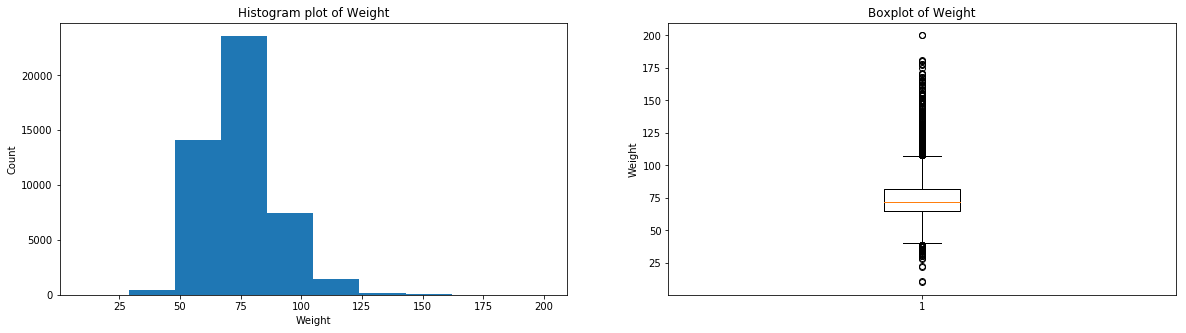

In [9]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data.Weight);
ax[0].set_title("Histogram plot of Weight")
ax[0].set_xlabel("Weight")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Weight")
ax[1].set_title("Boxplot of Weight")
ax[1].boxplot(data.Weight);
print("We can clearly see that our Weight data contains outlier because our data is highly skewed.")

**It is very unlikely we will see people who having a weight less than 40 kg given that the age of people given that the weight is not less than 120cm. So, we can clip the lower limit to 40 kg. Here also the higher values of the data seems fine.**

In [10]:
data.Weight=data.Weight.clip(lower=40)
test.Weight=test.Weight.clip(lower=40)

**Now, we have removed the outliers, we can calculate the BMI. After calculating the BMI, again we will check for outliers and remove those rows which have a really high or really low BMI values because this rows can be noise in our data which needs to be removed.**

In [11]:
data["BMI"]=data["Weight"]/((data.Height/100)**2)
test["BMI"]=test["Weight"]/((test.Height/100)**2)

**For the lower limit of BMI we have chosen 9 and higher limit is chosen as 80. Because, most of the BMI charts have this range of BMI.**

In [12]:
data[(data["BMI"]<9) | (data["BMI"]>80)]

,Age,Gender,Height,Weight,High Blood Pressure,Low Blood Pressure,Cholesterol,Glucose,Smoke,Alcohol,Exercise,Disease,BMI
25215,52,female,120,156.0,140,90,normal,normal,0,0,1,0,108.333333
29398,53,female,120,168.0,120,80,normal,normal,1,0,1,1,116.666667
29452,47,female,125,167.0,180,90,normal,high,0,0,1,1,106.880000
38669,57,female,122,161.0,120,80,normal,normal,0,0,1,1,108.169847
46982,54,female,120,159.0,200,100,too high,normal,0,0,0,1,110.416667


In [13]:
data.drop(data[(data["BMI"]<9) | (data["BMI"]>80)].index,inplace=True)

**Now, we check Low Blood Pressure and High Blood Pressure column if there are any outliers in the data.**

We can clearly see that our Low Blood Pressure data contains outlier because our data is very highly skewed


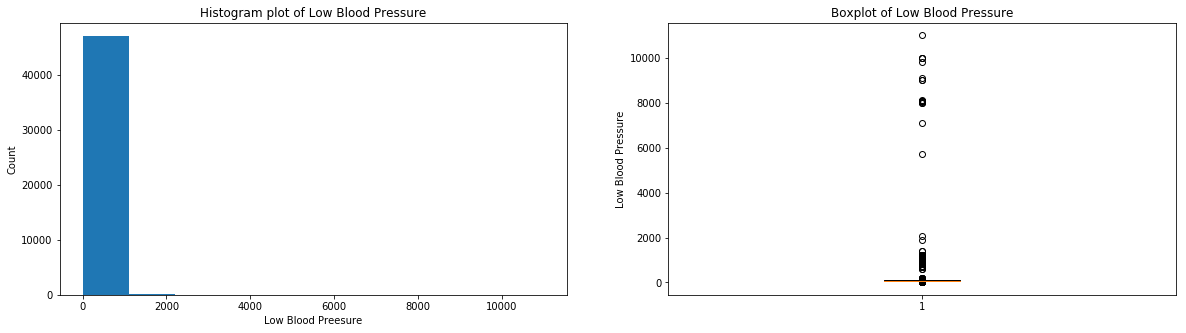

In [14]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data["Low Blood Pressure"]);
ax[0].set_title("Histogram plot of Low Blood Pressure")
ax[0].set_xlabel("Low Blood Preesure")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("Low Blood Pressure")
ax[1].set_title("Boxplot of Low Blood Pressure")
ax[1].boxplot(data["Low Blood Pressure"]);
print("We can clearly see that our Low Blood Pressure data contains outlier because our data is very highly skewed")

**We use the lower limit and higher limit of low blood pressure that is usually the limits used in the medical domain and trim the values.**

In [15]:
data["Low Blood Pressure"]=data["Low Blood Pressure"].clip(lower=40)
data["Low Blood Pressure"]=data["Low Blood Pressure"].clip(upper=160)
test["Low Blood Pressure"]=test["Low Blood Pressure"].clip(lower=40)
test["Low Blood Pressure"]=test["Low Blood Pressure"].clip(upper=160)

We can clearly see that our High Blood Pressure data contains outlier because our data is very highly skewed


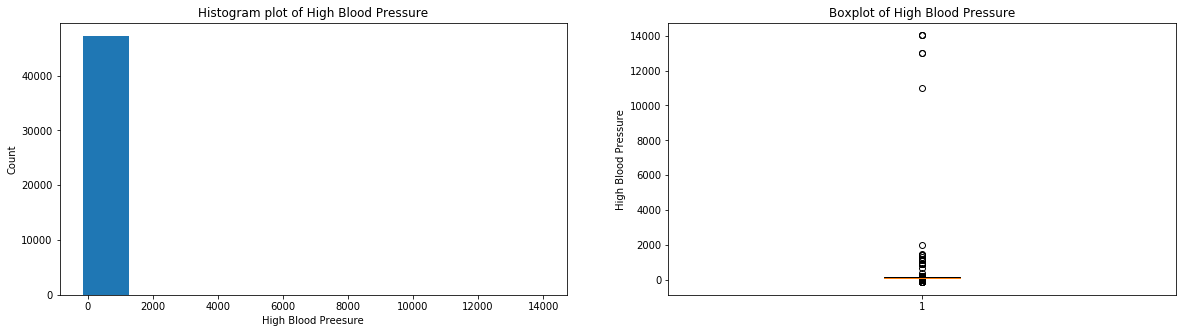

In [16]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
ax[0].hist(data["High Blood Pressure"]);
ax[0].set_title("Histogram plot of High Blood Pressure")
ax[0].set_xlabel("High Blood Preesure")
ax[0].set_ylabel("Count")
ax[1].set_ylabel("High Blood Pressure")
ax[1].set_title("Boxplot of High Blood Pressure")
ax[1].boxplot(data["High Blood Pressure"]);
print("We can clearly see that our High Blood Pressure data contains outlier because our data is very highly skewed")

**Again, we will trim the values using the limits used in the medical domain for High Blood Pressure.**

In [17]:
data["High Blood Pressure"]=data["High Blood Pressure"].clip(lower=60)
data["High Blood Pressure"]=data["High Blood Pressure"].clip(upper=250)
test["High Blood Pressure"]=test["High Blood Pressure"].clip(lower=60)
test["High Blood Pressure"]=test["High Blood Pressure"].clip(upper=250)

**Next, we check if there are any error in the values of other columns.**

In [18]:
for i in ['Gender','Cholesterol','Glucose', 'Smoke', 'Alcohol','Exercise', 'Disease']:
    print(data[i].unique())

['female' 'male']
['normal' 'high' 'too high']
['normal' 'high' 'too high']
[0 1]
[0 1]
[1 0]
[0 1]


**By itself, the distribution of age does not tell us much other than that there are no outliers as all the ages are reasonable. To visualize the effect of the age on the target, we will next make a kernel density estimation plot (KDE) colored by the value of the target. A kernel density estimate plot shows the distribution of a single variable and can be thought of as a smoothed histogram (it is created by computing a kernel, usually a Gaussian, at each data point and then averaging all the individual kernels to develop a single smooth curve). We will use the seaborn kdeplot for this graph.**

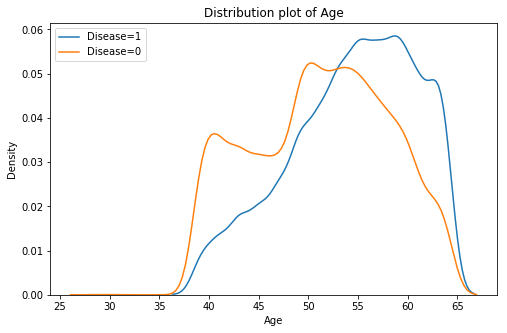

In [19]:
fig,ax=plt.subplots(1,figsize=(8,5))
ax.set_title("Distribution plot of Age")
ax.set_ylabel("Density")
sns.distplot(data.Age[data.Disease==1],hist=False,label="Disease=1",ax=ax)
sns.distplot(data.Age[data.Disease==0],hist=False,label="Disease=0",ax=ax);

**We see that the Disease=1 is slightly skewed to the right so we can expect the age to be helpful in predicting if a person has a disease or not.**

**We will divide the age groups to form bins to see that if it can help us to predict the outcome.**

In [20]:
data["Age_binned"]=pd.cut(data.Age,np.linspace(25,65,9),labels=np.arange(8))
test["Age_binned"]=pd.cut(test.Age,np.linspace(25,65,9),labels=np.arange(8))

Mean of the people having the disease by age group:


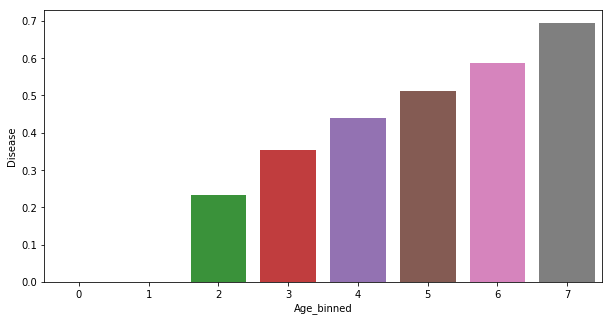

In [21]:
plt.figure(figsize=(10,5))
sns.barplot(data.groupby("Age_binned")["Disease"].mean().index,data.groupby("Age_binned")["Disease"].mean());
print("Mean of the people having the disease by age group:")

**Clearly, we can see that the binning can help us in the prediction of the disease outcome as the age increases the probabilty of getting the disease.**

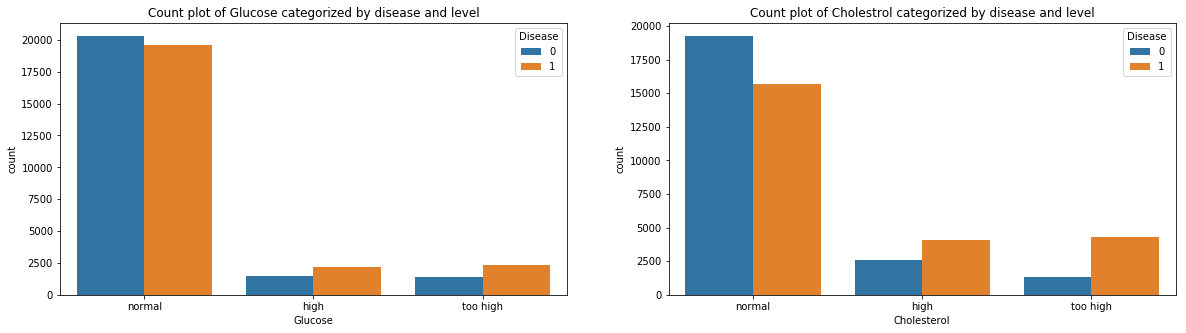

In [22]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
sns.countplot(data=data,x="Glucose",hue="Disease",ax=ax[0]);
ax[0].set_title("Count plot of Glucose categorized by disease and level")
sns.countplot(data=data,x="Cholesterol",hue="Disease",ax=ax[1])
ax[1].set_title("Count plot of Cholestrol categorized by disease and level");

In [23]:
# Function to plot ROC_AUC_curve

def ROC_AUC_curve(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

In [24]:
def ROC_AUC_curve_upgraded(model,model_name="Model"):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    lr_probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs
    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Decision Tree: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    # plot the roc curve for the model
    plt.figure(figsize=(8,4))
    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label=model_name)
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

## Data Transformation

**Converting the categorical columns into binary data.**

In [25]:
data.Gender.replace({"female":0,"male":1},inplace=True)
test.Gender.replace({"female":0,"male":1},inplace=True)

In [26]:
# One-hot encoding the categorical column
data=pd.get_dummies(data)
test=pd.get_dummies(test)

In [27]:
# Drop the columns because we drop one column when one hot encoding because n-1 contains the sufficient information so we can
# drop the nth column
data.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_binned_7'],inplace=True,axis=1)
test.drop(["Age",'Cholesterol_too high','Glucose_too high','Age_binned_7'],inplace=True,axis=1)

**We split the data to get our train and test, which will help us to evaluate how well our model runs on unseen data.**

In [28]:
X_train,X_test,y_train,y_test=train_test_split(data[data.columns[data.columns!="Disease"]],data.Disease,random_state=42,test_size=.15)

**Next we scale our data so that we can make the data suitable for training on some models which require preprocessed data.**

In [29]:
scaler=StandardScaler()

In [30]:
X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]]=scaler.fit_transform(X_train[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [31]:
test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]]=scaler.fit_transform(test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']])

D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda\envs\tensorflow\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [32]:
X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure','BMI']]=scaler.transform(X_test[['Height', 'Weight', 'Low Blood Pressure','High Blood Pressure',"BMI"]])

D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [33]:
final_prediction=pd.DataFrame()

In [34]:
final_prediction["ID"]=test.pop("ID")

## Model Building

**Metrics for tuning:** When predicting disease we use recall we want our model to predict the disease as much times from the actual number of cases of disease. The metrics for tuning here used is accuracy because the models were giving more stable results on test set when performing tuning using accuracy. Also, it is safe to use the accuracy as metrics because the classes are balanced and the recall score on test set are better when accuracy was used as tuning parameter rather than recall as the tuning metrics.

**Cross Validation:** 6 folds have been used for tuning the model to get a good generalized model and use as much as possible data for training the model. 

**Grid Search:** A simple grid search will try all combination for getting the hyperparameters which have the best average score on the all the testing folds.

**Epochs:** For each model, I have trained 50 epochs so that is able to reach the minimum of the loss function and output the best model.

**Model Checkpoint:** The model checkpoint makes sure that the model with the best validation accuracy is saved and used after the 50 epochs are completed.

### Logistic Regression

Logistic Regression are used when the data is linearly separable. It divides the binary data by making a linear decision boundary. C and type of penalty are two hyperparameters that are used to train a Logistic Regression classifier.

**Model Tuning:**

**C:** It is the inverse of the lambda. Smaller value specify more regularization 

**Penalty:** The types of penalty that can be used are l1 and l2. The l1 penalty has the characteristics of eliminating features by making its co-efficient 0. The l2 penalty does not eliminate features but it penalizes the effect of less useful features and makes their co-efficient close to 0. 

In [35]:
lr=LogisticRegression(random_state=42,solver="liblinear")

In [36]:
param_grid_lr={"C":[.001,.005,.01,.1,.2,.4,.8,1,10],"penalty":["l1","l2"]}

In [37]:
grid_search_lr=GridSearchCV(estimator=lr,param_grid=param_grid_lr,cv=6,scoring="accuracy")

In [38]:
import sklearn

In [39]:
grid_search_lr.fit(X_train,y_train)

GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.005, 0.01, 0.1, 0.2, 0.4, 0.8, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [40]:
best_params_lr=grid_search_lr.best_params_
print(best_params_lr)

{'C': 0.1, 'penalty': 'l1'}


In [41]:
#printing the training accuracy
accuracy_score(grid_search_lr.predict(X_train),y_train)

0.7275127004681741

In [42]:
#printing the testing accuracy
accuracy_score(grid_search_lr.predict(X_test),y_test)

0.7409341046987442

In [43]:
print(classification_report(y_true=y_test,y_pred=grid_search_lr.predict(X_test)))

              precision    recall  f1-score   support

           0       0.72      0.77      0.75      3501
           1       0.76      0.71      0.74      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.803


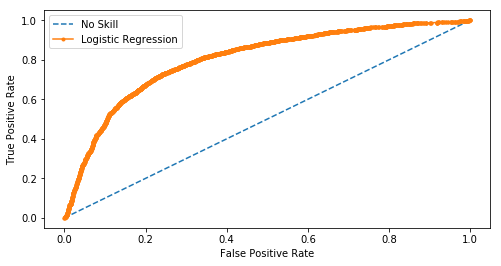

In [44]:
ROC_AUC_curve(model=grid_search_lr,model_name="Logistic Regression")

In [45]:
lr_coefficients=OrderedDict(sorted(zip(X_train.columns,grid_search_lr.best_estimator_.coef_[0]),reverse=True,key=lambda x:x[1]))

In [46]:
pd.Series(lr_coefficients)

High Blood Pressure    0.893014
Glucose_normal         0.261710
Glucose_high           0.241146
Low Blood Pressure     0.186552
Weight                 0.081726
BMI                    0.063021
Height                 0.000000
Age_binned_0           0.000000
Age_binned_1           0.000000
Gender                -0.033748
Smoke                 -0.143463
Exercise              -0.176750
Alcohol               -0.185109
Age_binned_6          -0.297212
Age_binned_5          -0.515505
Cholesterol_high      -0.608030
Age_binned_4          -0.669121
Age_binned_3          -0.906508
Cholesterol_normal    -1.001840
Age_binned_2          -1.374068
dtype: float64

**Here, we can see that Height, Age_binned_0, Age_binned_1 have been eliminated as our grid search uses the l1 penalty. The High Blood Pressure feature increases the odds of having the disease most and the Age binned 2 least affects the odds.**

In [47]:
test_predict_lr=grid_search_lr.predict(test)

### Decision Tree

A decision tree is a tree based model which makes prediction by learning simple decision rules using training data. A decision tress uses different methods like gini index or entropy to create a tree. Decision tree has one very important setback that it can easily overfit on train data. 

**Model Tuning:** 

 <br>**max_features:** The max_features is the number of features that will be used for making a single tree. For eg using "sqrt", the tree uses the square root of the number of total features in the data. Using auto is the same as making use of sqrt. The other values can be specifying the int(number of features to be used less than the total features), log, and proportion of the features to be used.
<br>**min_samples_leaf:** The minimum number of samples that should be there in leaf node. If the number is less then the leaf node is pruned.
<br>**min_samples_split:** The number of samples that should be present in the node for it to be split further.
<br>**maxDepth:** The maxdepth represents the depth of the tree. The deeper the tree, the more splits it has and it captures more information about the data. In order to avoid overfitting the data, we use the maxDepth to specify the depth till which the tree can split.

In [48]:
dt=DecisionTreeClassifier(random_state=42)

In [49]:
param_grid_dtree={'max_depth': [1,25,10, 20, 100],
            'max_features': ['auto','log2'],
            'min_samples_leaf': [10,30,50,100],
             'min_samples_split': [500,800,1000]}

In [50]:
grid_search_dt=GridSearchCV(estimator=dt,param_grid=param_grid_dtree,cv=6,scoring="accuracy",verbose=1,n_jobs=-1)

In [51]:
grid_search_dt.fit(X_train,y_train)

Fitting 6 folds for each of 120 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  62 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done 662 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:   13.3s finished


GridSearchCV(cv=6, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_split': [500, 800, 1000], 'max_depth': [1, 25, 10, 20, 100], 'min_samples_leaf': [10, 30, 50, 100], 'max_features': ['auto', 'log2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

In [52]:
best_params_dt=grid_search_dt.best_params_
print(best_params_dt)

{'min_samples_split': 500, 'max_depth': 20, 'min_samples_leaf': 10, 'max_features': 'auto'}


In [53]:
#printing the training accuracy
accuracy_score(grid_search_dt.predict(X_train),y_train)

0.7255702759238968

In [54]:
#printing the testing accuracy
accuracy_score(y_test,grid_search_dt.predict(X_test))

0.7340200366868915

In [55]:
print(classification_report(y_test,grid_search_dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74      3501
           1       0.76      0.69      0.72      3586

   micro avg       0.73      0.73      0.73      7087
   macro avg       0.74      0.73      0.73      7087
weighted avg       0.74      0.73      0.73      7087



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.794


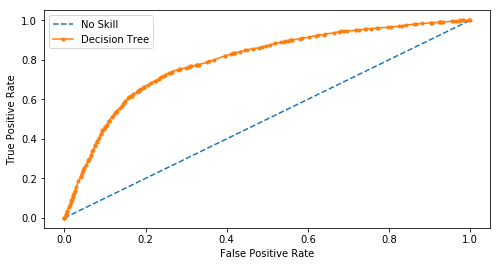

In [56]:
ROC_AUC_curve(model=grid_search_dt,model_name="Decision Tree")

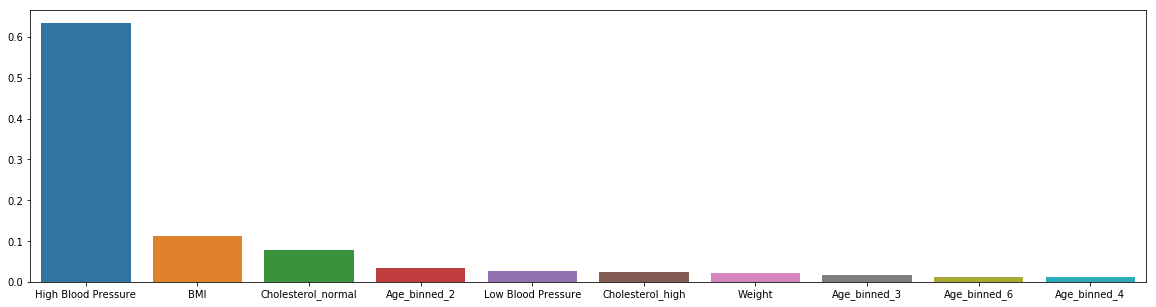

In [57]:
plt.figure(figsize=(20,5))
feature_importance_dt=OrderedDict(sorted(zip(X_train.columns,grid_search_dt.best_estimator_.feature_importances_),reverse=True,key=lambda x:x[1]))
sns.barplot(list(feature_importance_dt.keys())[:10],list(feature_importance_dt.values())[:10]);

In [58]:
test_predict_dt=grid_search_dt.predict(test)

### ANN 0

A neural network with 0 hidden layer and the ouput layer with a sigmoid function is similar to logistic regression function.
The number of nodes in a hidden layer were chosen by taking a number which is the mean of the number of perceptrons in the layers on the left and right side. Apart from that, manual tuning of the hyperparameter was also tried and we used the results of combination which were the best.  

**Model Tuning:** 

 <br>**loss function:** The loss function we have used here is binary cross entropy. In binary cross entropy, if the model makes wrongly predicts the class with high confidence then the error will be very high. It is a popular function that is used for binary classification problems.
<br>**batch size:** The batch size that is fed to the model for a single update to the weights. If the batch size is 1 then the loss function will move towards the minima in not a very smooth manner.
<br>**optimizer:** The optimizer that we have used is stochastic gradient descent which is an iterative method for optimizing the objective function.

In [59]:
mc_0 = ModelCheckpoint('best_model_ann0.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [60]:
ann0 = Sequential()
ann0.add(Dense(1, activation='sigmoid', input_shape=(20,)))

In [61]:
ann0.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [62]:
ann0.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0,validation_data=(X_test,y_test),callbacks=[mc_0])

In [63]:
# loads the weights of the best model
ann0.load_weights("best_model_ann0.h5")

In [64]:
#printing the training accuracy
accuracy_score((ann0.predict(X_train)>0.5).astype(int),y_train)

0.725894013347943

In [65]:
#printing the testing accuracy
accuracy_score(y_test,(ann0.predict(X_test)>0.5).astype(int))

0.7431917595597572

In [66]:
print(classification_report(y_true=y_test,y_pred=(ann0.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.73      0.75      0.74      3501
           1       0.75      0.73      0.74      3586

   micro avg       0.74      0.74      0.74      7087
   macro avg       0.74      0.74      0.74      7087
weighted avg       0.74      0.74      0.74      7087



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.804


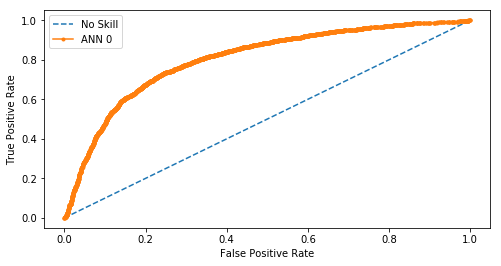

In [67]:
ROC_AUC_curve_upgraded(ann0,model_name="ANN 0")

In [68]:
# Changing the threshold to get a better recall
test_predict_ann0=(ann0.predict_proba(test)>0.5).astype(int)

### ANN 1

A neural network with 1 hidden layer and the ouput layer is a sigmoid function.

**Model Tuning:** 

<br>**loss function:** The loss function we have used here is binary cross entropy. In binary cross entropy, if the model makes wrongly predicts the class with high confidence then the error will be very high. It is a popular function that is used for binary classification problems.
<br>**batch size:** The batch size that is fed to the model for a single update to the weights. If the batch size is 1 then the loss function will move towards the minima in not a very smooth manner.
<br>**activation:** The relu activation function is good choice as it is positive for positive values and 0 for negative values. It doesn't have the vanishing gradient problem. 
<br>**optimizer:** The optimizer that we have used is stochastic gradient descent which is an iterative method for optimizing the objective function.
<br>**hidden layer:** The hidden layer contains 11 nodes of perceptrons.

In [69]:
mc_1 = ModelCheckpoint('best_model_ann1.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [70]:
ann1 = Sequential()
ann1.add(Dense(11, activation='relu', input_shape=(20,)))
ann1.add(Dense(1, activation='sigmoid', input_shape=(11,)))

In [71]:
ann1.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [72]:
ann1.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0,validation_data=(X_test,y_test),callbacks=[mc_1])

In [73]:
# loads the weights of the best model
ann1.load_weights("best_model_ann1.h5")

In [74]:
#printing the training accuracy
accuracy_score((ann1.predict(X_train)>0.5).astype(int),y_train)

0.7327174021316865

In [75]:
#printing the testing accuracy
accuracy_score(y_test,(ann1.predict(X_test)>0.5).astype(int))

0.7464371384224636

In [76]:
print(classification_report(y_true=y_test,y_pred=(ann1.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      3501
           1       0.75      0.74      0.75      3586

   micro avg       0.75      0.75      0.75      7087
   macro avg       0.75      0.75      0.75      7087
weighted avg       0.75      0.75      0.75      7087



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.811


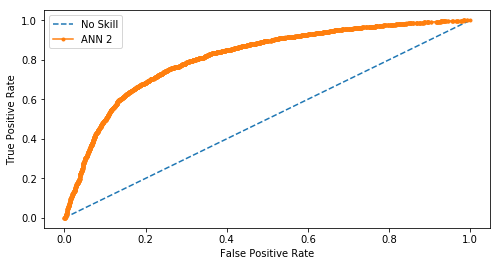

In [77]:
ROC_AUC_curve_upgraded(ann1,model_name="ANN 2")

In [78]:
# Changing the threshold to get a better recall
test_predict_ann1=(ann1.predict_proba(test)>0.5).astype(int)

### ANN 2

A neural network with 2 hidden layer and the ouput layer is a sigmoid function.

**Model Tuning:** 

<br>**loss function:** The loss function we have used here is binary cross entropy. In binary cross entropy, if the model wrongly predicts a class with high confidence then the error will be very high. It is a popular function that is used for binary classification problems.
<br>**batch size:** The batch size that is fed to the model for a single update to the weights. If the batch size is 1 then the loss function will move towards the minima in not a very smooth manner.
<br>**optimizer:** The optimizer that we have used is stochastic gradient descent which is an iterative method for optimizing the objective function.
<br>**activation:** The relu activation function is good choice as it is positive for positive values and 0 for negative values. It doesn't have the vanishing gradient problem. 
<br>**hidden layer:** 1st hidden layer- 11 nodes of perceptrons   2nd hidden layer- 6 nodes of perceptrons.

In [79]:
mc_2 = ModelCheckpoint('best_model_ann2.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

In [80]:
ann2 = Sequential()
ann2.add(Dense(11, activation='relu', input_shape=(20,)))
ann2.add(Dense(6, activation='relu', input_shape=(11,)))
ann2.add(Dense(1, activation='sigmoid', input_shape=(6,)))

In [81]:
ann2.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [82]:
ann2.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0,validation_data=(X_test,y_test),callbacks=[mc_2])

In [83]:
# loads the weights of the best model
ann2.load_weights("best_model_ann2.h5")

In [84]:
#printing the training accuracy
accuracy_score((ann2.predict(X_train)>0.5).astype(int),y_train)

0.7317461898595478

In [85]:
#printing the testing accuracy
accuracy_score(y_test,(ann2.predict(X_test)>0.5).astype(int))

0.7478481727105969

In [86]:
print(classification_report(y_true=y_test,y_pred=(ann2.predict(X_test)>0.5).astype(int)))

              precision    recall  f1-score   support

           0       0.74      0.76      0.75      3501
           1       0.76      0.74      0.75      3586

   micro avg       0.75      0.75      0.75      7087
   macro avg       0.75      0.75      0.75      7087
weighted avg       0.75      0.75      0.75      7087



No Skill: ROC AUC=0.500
Decision Tree: ROC AUC=0.812


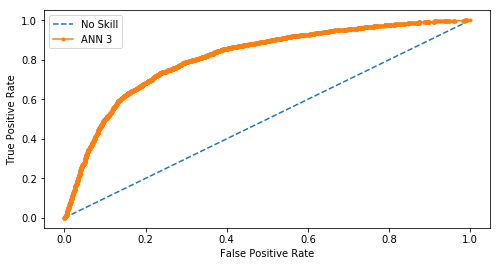

In [87]:
ROC_AUC_curve_upgraded(ann2,model_name="ANN 3")

In [88]:
# Changing the threshold to get a better recall
test_predict_ann2=(ann2.predict_proba(test)>0.5).astype(int)

## Prediction and Interpretation

In [99]:
summary=pd.DataFrame({"Algorithm":["NBC","KNN","SVM-Linear","SVM-RBF","RF","GBM","LR","DT","ANN0","ANN1","ANN2"],
                      "Recall":[0.72,0.75,.70,.70,.74,.76,.71,0.69,.73,.74,.74],
                      "Accuracy":[0.7061,0.7381,0.7392,.7426,.7378,.7441,.7409,.7340,.7431,.7464,.7478],
                      "Avg. time taken to train one model(mins)":[0.001,.25,0.017,1.14,0.05,0.09,0.02,0.001,.15,0.08,.17],
                      "Avg. to grid search(mins)":[0.025,24.2,0.42,205,32.9,50.9,.34,.34,7.5,4.17,8.3],
                      "Hyperparameters":[{'var_smoothing': 0.1},{'p': 1, 'n_neighbors': 100, 'weights': 'uniform'},
                                         {'C': 0.01, 'penalty': 'l2'},{'C': 0.8, 'gamma': 0.1},
                                        {'min_samples_split': 500, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'n_estimators': 2000, 'max_depth': 10},
                                        {'min_samples_split': 1000, 'max_features': 'auto', 'n_estimators': 100, 'min_samples_leaf': 30, 'subsample': 0.6, 'max_depth': 5},
                                        {'C': 0.1, 'penalty': 'l1'},{'min_samples_split': 500, 'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 10},
                                        {'loss_function':"binary_crossentropy","epochs":50,"batch_size":16,"optimizer":"sgd"},
                                        {'loss_function':"binary_crossentropy","epochs":50,"batch_size":16,"optimizer":"sgd"},
                                        {'loss_function':"binary_crossentropy","epochs":50,"batch_size":16,"optimizer":"sgd"}]})

In [100]:
summary.sort_values(by="Accuracy",ascending=False)

,Accuracy,Algorithm,Avg. time taken to train one model(mins),Avg. to grid search(mins),Hyperparameters,Recall
10,0.7478,ANN2,0.170,8.300,"{'loss_function': 'binary_crossentropy', 'batc...",0.74
9,0.7464,ANN1,0.080,4.170,"{'loss_function': 'binary_crossentropy', 'batc...",0.74
5,0.7441,GBM,0.090,50.900,"{'max_depth': 5, 'min_samples_split': 1000, 'm...",0.76
8,0.7431,ANN0,0.150,7.500,"{'loss_function': 'binary_crossentropy', 'batc...",0.73
3,0.7426,SVM-RBF,1.140,205.000,"{'C': 0.8, 'gamma': 0.1}",0.70
6,0.7409,LR,0.020,0.340,"{'C': 0.1, 'penalty': 'l1'}",0.71
2,0.7392,SVM-Linear,0.017,0.420,"{'C': 0.01, 'penalty': 'l2'}",0.70
1,0.7381,KNN,0.250,24.200,"{'p': 1, 'n_neighbors': 100, 'weights': 'unifo...",0.75
4,0.7378,RF,0.050,32.900,"{'min_samples_leaf': 10, 'n_estimators': 2000,...",0.74
7,0.7340,DT,0.001,0.340,"{'min_samples_leaf': 10, 'max_depth': 20, 'min...",0.69


In [101]:
feature_importance=pd.DataFrame({"Random Forest":['High Blood Pressure','Low Blood Pressure','Cholesterol_normal','BMI','Age_binned_2','Age_binned_3',
                              'Weight','Cholesterol_high','Age_binned_4','Age_binned_6'],
            "GBM":['High Blood Pressure','Cholesterol_normal','BMI','Cholesterol_high','Age_binned_2','Age_binned_3','Low Blood Pressure',
 'Weight','Age_binned_4','Height'],
            "Decision Tree":['High Blood Pressure','BMI','Cholesterol_normal','Age_binned_2','Low Blood Pressure','Cholesterol_high',
 'Weight','Age_binned_3','Age_binned_6','Age_binned_4']})
print("Feature Importance by Highest to Lowest(Top 10)")
feature_importance

Feature Importance by Highest to Lowest(Top 10)


,Decision Tree,GBM,Random Forest
0,High Blood Pressure,High Blood Pressure,High Blood Pressure
1,BMI,Cholesterol_normal,Low Blood Pressure
2,Cholesterol_normal,BMI,Cholesterol_normal
3,Age_binned_2,Cholesterol_high,BMI
4,Low Blood Pressure,Age_binned_2,Age_binned_2
5,Cholesterol_high,Age_binned_3,Age_binned_3
6,Weight,Low Blood Pressure,Weight
7,Age_binned_3,Weight,Cholesterol_high
8,Age_binned_6,Age_binned_4,Age_binned_4
9,Age_binned_4,Height,Age_binned_6


**Interpretation and Conclusion:**

**As the number of hidden layers increased in the neural network, the training accuracy increased but the validation accuracy did not increase after a point and started to be very low compared to the training accuracy. This was a sign of overfitting on the training data.**

**From our summary table, logistic regression, linear svm and ANN0 can be seen to be very close to each other in the table as they have similar validation accuracy. The results are close due to the fact that all of them use a linear boundary to separate the classes.**

**From the feature importance table, we can see that top 10 features for all the tree based algorithms are the same. Only the order of importance has changed. High Blood Pressure is the most important feature in predicting the disease as it is the top feature for all the algorithms.**

**The ANN02 has the highest accuracy. The area under the curve is close to 0.8 for all the models which means that the model are not just randomly predicting and the true positive rate is good. The recall is also good for all the models with GBM having the highest recall which was achieved after tuning the threshold in the last assignment.**

**All the models have testing accuracy close to the training accuracy which mean that the models are able to generalize the data nicely. Also, it means that the training data and the testing data had similar distributions. So, the performance was the same on both the sets.**

**Our svm linear model, ANN0 and Logistic Regression has a good accuracy in predicting the data so maybe it means that a linear decision boundary could work for separating the classes.**

In [102]:
# Creating the columns for all the model predictions and storing them in the dataframe
final_prediction["DT"]=test_predict_dt
final_prediction["LR"]=test_predict_lr
final_prediction["ANN0"]=test_predict_ann0
final_prediction["ANN1"]=test_predict_ann1
final_prediction["ANN2"]=test_predict_ann2

In [103]:
# Storing the final predictions in csv file
final_prediction.to_csv("test_prediction.csv",index=False)